# Identifying birdcalls with deeplearning

Over a million species face extinction right now and we're losing species faster than we can count them. While rainforests capture the spotlight, a quieter extinction is happening all around us—in the soundscapes we barely notice. Organizations such as Earth Species Initiative, Hula, Biometrio etc. aren't waiting for boots on the ground to disappear into the wilderness; they're training AI to listen instead.

## Why & How?

What if you could monitor an entire ecosystem without stepping foot in it? A single passive acoustic monitor—a battery-powered device no bigger than a shoebox—can listen 24/7, capturing the calls of species too shy to let humans near them. Deploy a network of them, pair their recordings with machine learning models trained on repositories like Xeno-canto's 1+ million bird recordings, and suddenly you can track biodiversity across landscapes faster and cheaper than traditional field surveys ever allowed. That's the promise of passive acoustic monitoring: turning the invisible language of nature into quantifiable conservation data. In this guide, we'll try to build our own deep learning model to do exactly that.

Deep learning already leveraging acoustics data to try to find known bird calls 
- presence and diversity of birds and other animals is a sign of healthy bio-diversity
- increasingly, we are also trying to detect in-species sounds:


The following tutorial is based on this [github repo](https://github.com/samsaara/birdcalls) that I created where you can find more information.

In [ ]:
#| code-fold: true

import os
os.chdir('..')

import gc
import torch
import IPython.display as ipd

from ast import literal_eval
from src.modeling import Model
from src.processing import plot_batch
from src.utils import get_resp, get_metadata_for_birds
from src.audio import load_audio, get_melspec, plot_spec

To download metadata of recordings programatically from `Xeno-Canto`, you'd need an API key that's freely available once you register.

I'm interested in identifying bird species in a small region and for that we can train a simple deeplearning model. Instead of training a model on the recordings from a small region, for which we may or may not have enough data, we instead find out which birds are typically found in the said region and try to get recordings for those species from a wider area (e.g., a city/country/continent etc.). Then we can test it to identify birds in our narrow region.

I'm interested in Munich city but first, let's find out how many recordings for birds we have for Germany...

# EDA

In [ ]:
query = f"cnt:germany+grp:birds"
data = get_resp(query)

In [5]:
for k, v in data.items():
    if k!= 'recordings':
        print(k, v)

numRecordings 36264
numSpecies 340
page 1
numPages 726


Wow! we have ~36K recordings of 340 different species of birds... that's very interesting. Can't analyse all here... so let's take a subset from Munich... We draw a bounding box

In [ ]:
query = f"box:48,11.34,48.282,11.851+grp:birds"
data = get_resp(query, per_page=500)

In [8]:
for k, v in data.items():
    if k!= 'recordings':
        print(k, v)

numRecordings 102
numSpecies 58
page 1
numPages 1


much more manageable... We'll get 10 recording samples for each of these 58 species from a much wider area and store it locally.

In [9]:
df = pd.DataFrame(data['recordings'])
df.shape

(102, 37)

In [10]:
df.sample(3).T

83  \
id                                                        652760   
gen                                                     Saxicola   
sp                                                      rubicola   
ssp                                                                
grp                                                        birds   
en                                            European Stonechat   
rec                                                 Mathias Götz   
cnt                                                      Germany   
loc            München (near  Garching bei München), Oberbaye...   
lat                                                      48.2184   
lon                                                      11.6062   
alt                                                          500   
type                                                        call   
sex                                                                
stage                                                              
method                                           field recording   
url                                      //xeno-canto.org/652760   
file                      https://xeno-canto.org/652760/download   
file-name              XC652760-Schwarzkehlchen - Kontaktruf.mp3   
sono           {'small': '//xeno-canto.org/sounds/uploaded/FY...   
osci           {'small': '//xeno-canto.org/sounds/uploaded/FY...   
lic                 //creativecommons.org/licenses/by-nc-sa/4.0/   
q                                                              B   
length                                                      0:42   
time                                                       12:30   
date                                                  2021-05-24   
uploaded                                              2021-05-29   
also                                                          []   
rmk                                                                
animal-seen                                                  yes   
playback-used                                                 no   
temp                                                               
regnr                                                              
auto                                                          no   
dvc                                                                
mic                                                                
smp                                                        44100   

                                                              54  \
id                                                        366346   
gen                                                 Phylloscopus   
sp                                                     collybita   
ssp                                                                
grp                                                        birds   
en                                             Common Chiffchaff   
rec                                                Michele Peron   
cnt                                                      Germany   
loc            Bavaria (near  Garching bei München), Oberbaye...   
lat                                                      48.2489   
lon                                                      11.6532   
alt                                                          480   
type                                                        call   
sex                                                                
stage                                                              
method                                           field recording   
url                                      //xeno-canto.org/366346   
file                      https://xeno-canto.org/366346/download   
file-name                 XC366346-Zilpzalp_sweeoo_einsilbig.mp3   
sono           {'small': '//xeno-canto.org/sounds/uploaded/DB...   
osci           {'small': '//xeno-canto.org/sounds

In [ ]:
#| code-fold: true

# df.to_csv('data/munich_birds.csv', index=False)
# df = pd.read_csv('data/munich_birds.csv')
# df.shape

# df_recs = pd.to_csv('data/munich_birds_recordings_samples_metadata.csv', index=False)
# df_recs = pd.read_csv('data/munich_birds_recordings_samples_metadata.csv')

In [ ]:
df_recs = get_metadata_for_birds(df)

In [12]:
df_recs.sample(3).T

151   \
id                                                       1062867   
gen                                                       Alauda   
sp                                                      arvensis   
ssp                                                          NaN   
grp                                                        birds   
en                                              Eurasian Skylark   
rec                                        David Darrell-Lambert   
cnt                                               United Kingdom   
loc                                    Lower Abbey Farm, Suffolk   
lat                                                      52.2355   
lon                                                       1.5998   
alt                                                            4   
type                                                        call   
sex                                                    uncertain   
stage                                                  uncertain   
method                                           field recording   
url                                     //xeno-canto.org/1062867   
file                     https://xeno-canto.org/1062867/download   
file-name      XC1062867-Eurasian-Skylark-call-very-good-2020...   
sono           {'small': '//xeno-canto.org/sounds/uploaded/AY...   
osci           {'small': '//xeno-canto.org/sounds/uploaded/AY...   
lic                    //creativecommons.org/licenses/by-nc/4.0/   
q                                                              A   
length                                                      0:13   
time                                                       10:00   
date                                                  2020-04-24   
uploaded                                              2025-12-05   
also                                                          []   
rmk                                                          NaN   
animal-seen                                                  yes   
playback-used                                                 no   
temp                                                         NaN   
regnr                                                        NaN   
auto                                                          no   
dvc                                      Sound devices mix pre 3   
mic                                           Telinga pro 8 MKII   
smp                                                        48000   
code                                             alauda_arvensis   

                                                            2309  \
id                                                        947332   
gen                                                      Poecile   
sp                                                     palustris   
ssp                                                          NaN   
grp                                                        birds   
en                                                     Marsh Tit   
rec                                                    Ulf Elman   
cnt                                                       Sweden   
loc                                    Härjarö, Trögden, Uppland   
lat                                                      59.4628   
lon                                                      17.4141   
alt                                                            0   
type                                                        call   
sex                                                          NaN   
stage                                                        NaN   
method                                           field recording   
url                                      //xeno-canto.org/947332   
file                      https://xeno-canto.org/947332/download   
file-name             XC947332-241110_2680C-Entita-stjärtmes.mp3   
sono           {'small': '//xeno-canto.org/soun

In [13]:
df_recs.q.value_counts(dropna=False, normalize=True)

q
A           0.987018
B           0.011930
C           0.000702
no score    0.000351
Name: proportion, dtype: float64

Nice, almost all of them has high quality recordings...

In [14]:
df_recs.cnt.value_counts(dropna=False, normalize=True).head(10)

cnt
France            0.203860
Sweden            0.187719
Spain             0.092281
Poland            0.083860
United Kingdom    0.069825
Germany           0.053684
Netherlands       0.041754
Italy             0.035789
Norway            0.025965
Portugal          0.019298
Name: proportion, dtype: float64

Interesting! Most of the recordings for the birds that I am interested in from Munich comes not from Germany but from neighbouring countries... this provides insights as to the habitat spread of a species of interest.

We will now store these recordings...

In [ ]:
get_data(df_recs)

## Spectrograms

In [16]:
sample_audio = 'data/train_audio/asio_otus/592319.mp3'

In [17]:
ipd.Audio(sample_audio)

We will use [librosa](https://librosa.org/) to handle loading audio of various formats. Make sure `ffmpeg` is installed in your system.

In [18]:
y, sr = load_audio(sample_audio)
y.shape, sr

((2009408,), 44100)

This 45 second clip contains more than 2M data points because of the high sampling rate.

We shall now extract mel-spectrogram from the wave data. There're many articles out there explaining these, so I would refrain from going into detail. In short, audio is an analog signal that we convert into digital format with a certain sampling rate. Because it is a signal, we can run Fourier Transforms (FT) to decompose it into individual frequencies. But given the non-periodic nature of human speech or bird calls etc., we instead do STFT (Short Time FT) over a window. There can be many frequencies overlapping at any given point of time and these can be visualized as a [*spectrogram*](https://en.wikipedia.org/wiki/Spectrogram). Because of the non-linear nature of our innate hearing capabilities & constraints, we convert these frequencies to [Mel Scale](https://en.wikipedia.org/wiki/Mel_scale). Mel-Spectrograms are just that.

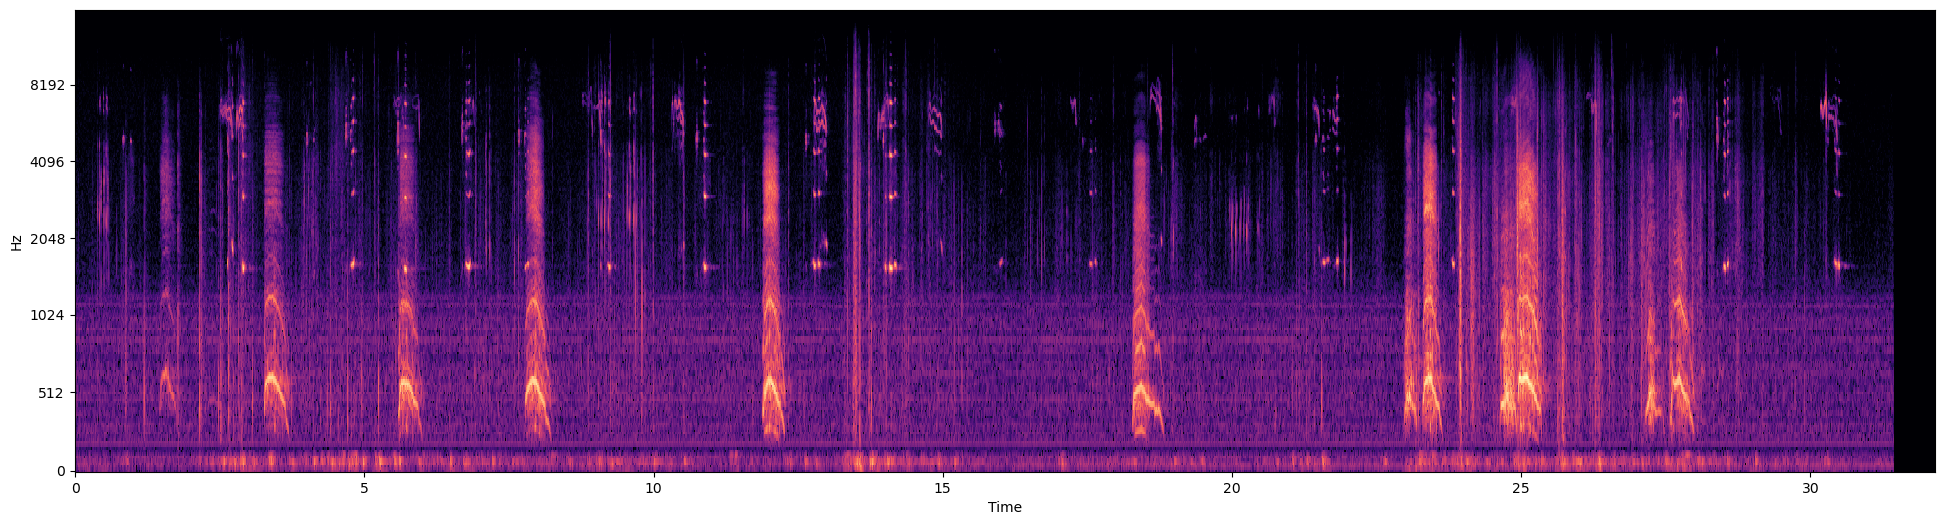

In [19]:
mel_dB = get_melspec(y, sr, plot=True)

Let's zoom into a small section to see more details of the harmonics or overtones...

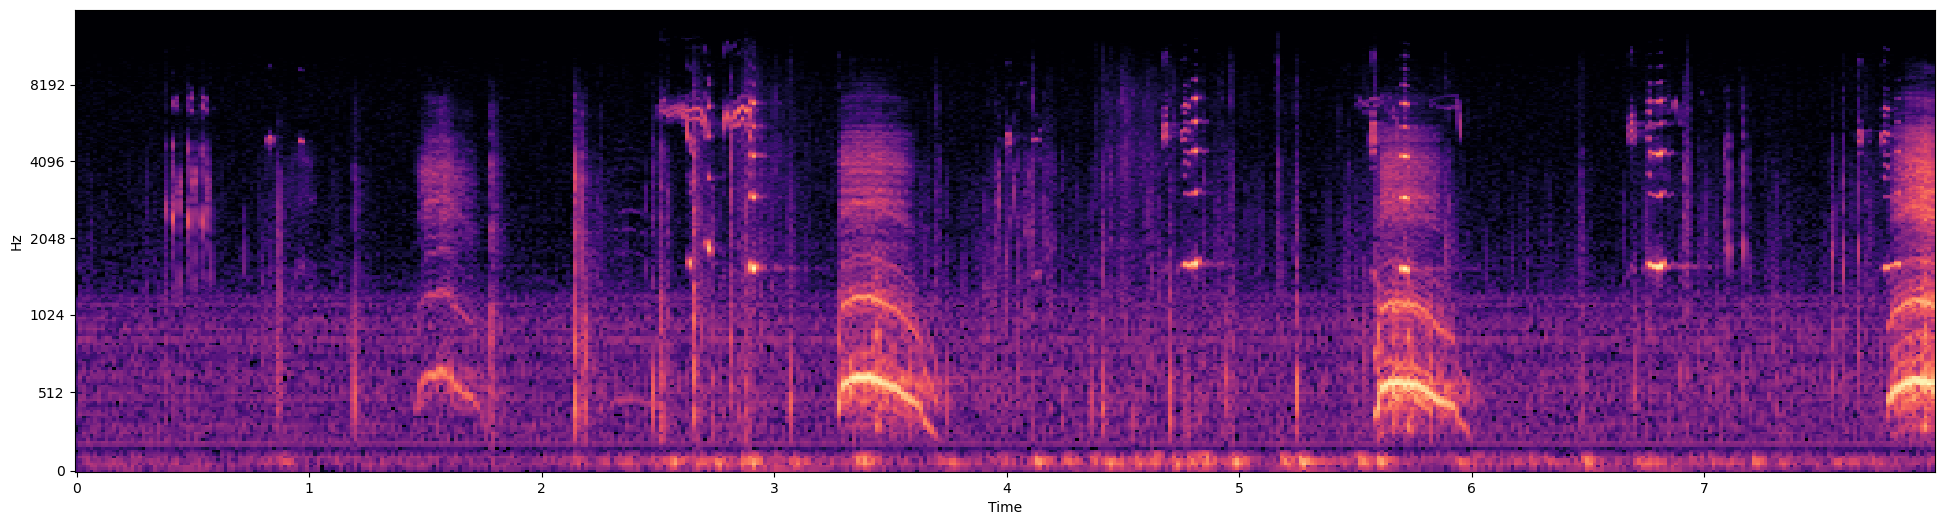

In [20]:
plot_spec(mel_dB[:, :500])

In [21]:
df_recs.smp.value_counts(normalize=True, dropna=False)

smp
48000    0.500702
44100    0.420702
32000    0.037544
96000    0.023158
24000    0.013684
22050    0.002807
16000    0.000702
8000     0.000351
88200    0.000351
Name: proportion, dtype: float64

good to see that most of the recordings have high sampling rates

In [22]:
df_recs[df_recs.also != "[]"].also.apply(lambda x: ', '.join(literal_eval(x))).values

array(['Loxia curvirostra', 'Loxia curvirostra, Troglodytes troglodytes',
       'Fringilla coelebs, Turdus merula', ...,
       'Fringilla coelebs, Prunella modularis, Homo sapiens, Bos taurus',
       'Columba palumbus, Turdus philomelos, Gallus gallus, Corvus corone, Erithacus rubecula, Troglodytes troglodytes',
       'Gallus gallus, Corvus corone, Coloeus monedula, Erithacus rubecula, Troglodytes troglodytes, Bos taurus'],
      shape=(1090,), dtype=object)

the metadata also includes other bird (& animal?) species that also appear in a given recording. We can also leverage these when doing multi label classification.

# Train Model

We will build a very simple starter ResNet based model to identify birds calls/songs but this can be adapted to any species. It works the following way:

1. Obtain MelSpectrograms of the audio recordings of your species of interest
2. During training:
   1. randomly extract `n` seconds of audio data from the whole audio file
   2. generate mel-spectrogram of it
   3. pre-process and transform it into a single channel image (a square array)
   4. train on these patches

We keep the pretrained weights, freeze the resnet backbone and adjust the no. of last linear layer's output features to the no. of classes we have in our dataset. We also change the inputs of the first CNN layer given that we have a single channel image.


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mdl = Model(device, pretrained=True, freeze_backbone=True)
mdl.set_dataloaders("data/train_audio/", batch_size=32)
for x, y in mdl.train_dl:
    break
x.shape, y.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 57]))

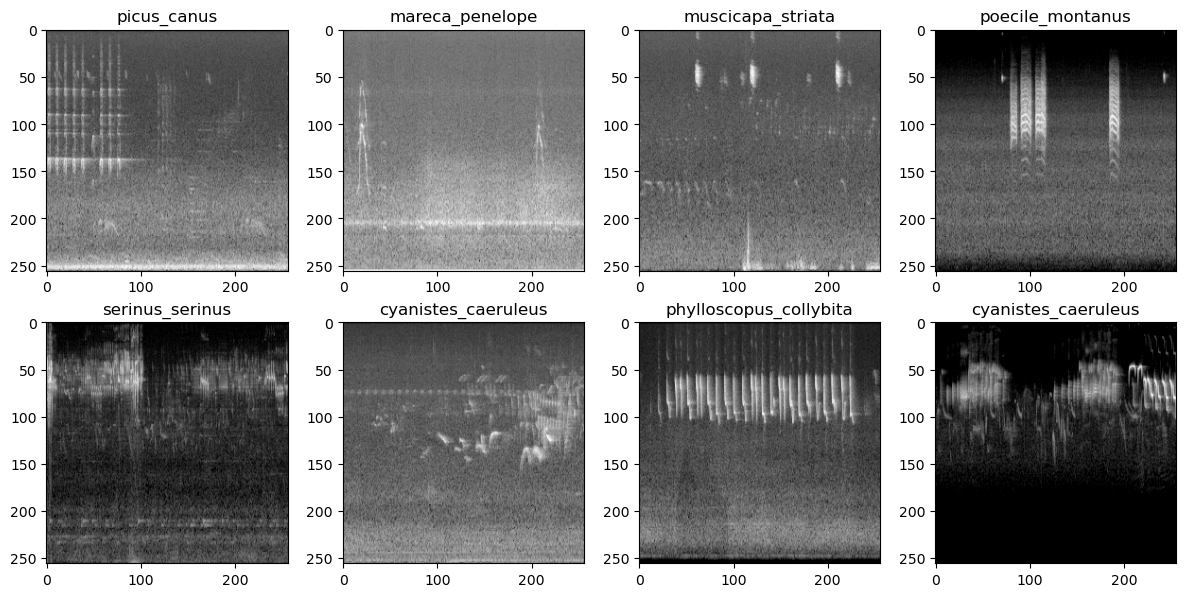

In [28]:
plot_batch(x[:8], y[:8])

we can now train for some epochs...You can also load the model from your earlier training checkpoint to continue training or for inference.

In [ ]:
mdl.train(num_epochs=5)

In [ ]:
mdl.load_from_chkpt('data/model_checkpoints/chkpt_12.pth')

Let's load a sample audio file for inference...

In [31]:
fp = 'data/train_audio/corvus_corone/592284.mp3'
mdl.make_preds(fp)

'corvus_corone'

cool!

# HF Spaces Demo

The model's also hosted as a demo on huggingface spaces: [munich-bird-identifier](https://huggingface.co/spaces/samsaara/munich_bird_identifier) although keep in mind that the results aren't that accurate as it's just a PoC.

# Next Steps:

Our current model barely scratches the surface. It just represents one of the many approaches for understanding how deep learning tackles bioacoustics. However, the field is advancing rapidly, and there are numerous directions to extend and enhance our approach.

Real-world bird classification demands moving beyond single-channel, binary classification models toward greater sophistication. We can do that by incorporating multi-channel spectrograms that capture complementary acoustic features (Mel-spectrograms at varying resolutions, delta features, chromagrams), then expand to multi-label scenarios where multiple species vocalize simultaneously. On top of that, we can develop multimodal models fusing acoustic data with temporal (time of day, season), spatial, and weather metadata; information that dramatically improves predictions since bird activity patterns are highly context-dependent. Google's [Massive Sound Embedding Benchmark (MSEB)](https://research.google/blog/from-waveforms-to-wisdom-the-new-benchmark-for-auditory-intelligence/), presented at NeurIPS 2025, provides an extensible framework for evaluating such multimodal sound models, with BirdSet demonstrating how bioacoustics integrates into broader auditory intelligence research.

We also have to understand the resource constraints such as compute, power etc. when deploying models on to edge devices where light-weight models such as EfficientNet shines.

Standardized benchmarks like BirdSet become essential for validating progress against state-of-the-art approaches. BirdSet aggregates diverse datasets into a unified framework exposing models to both focal recordings (isolated calls from Xeno-Canto) and soundscape recordings (complex passive monitoring data), explicitly testing for the "covariate shift" problem where models trained on clean recordings struggle with real-world acoustic environments. By evaluating against BirdSet's standardized pipeline and baseline results, we can quickly identify strengths and weaknesses in our model. Additionally, MSEB's inclusion of BirdSet enables evaluation across downstream tasks beyond classification such as acoustic retrieval, clustering unknown species, and temporal segmentation of vocalizations within long recordings. Google's [Perch 2.0](https://research.google/pubs/perch-20-the-bittern-lesson-for-bioacoustics/) model released recently got SoTA results on this dataset.

Apart from that, kaggle also hosts annual BirdCLEF competitions for bioacoustics wherein massive soundscape datasets get dissected by top teams who then publish their full solution writeups as open-source treasure. This knowledge sharing featuring cutting-edge techniques seeps straight from notebooks into real-world conservation tools. With models and datasets like these, only our imagination limits what we can achieve towards conservation of biodiversity.

Thanks a lot for reading! Auf Wiedersehen 👋!